In [1]:
import pandas as pd
import numpy as np
import functools as ft
import itertools as it
import multiprocessing as mp
import scipy.sparse as sp
from go_learning_helpers import *
import itertools
import matplotlib.pyplot as plt
from gensim import corpora
from collections import defaultdict
from gensim.models import TfidfModel
from collections import Counter
import json

%matplotlib notebook

In [2]:
spinglass_clusters = pd.read_csv('../results/consensus_spinglass.txt', sep ='\t')
spinglass_clusters.head(5)
spin = pd.DataFrame(spinglass_clusters.set_index('names')['cluster'])
spin.head(5)

,cluster
names,
PAK1,1
ERBB2,2
RON,3
YES,3
TYRO3,3


In [3]:
cluster_dir = '../results/'
louvain_file = 'louvain_clusters.txt'
louv = pd.read_csv(cluster_dir+louvain_file, sep='\t',index_col=0)
louv.head(5)

,cluster
names,
PAK1,5
ERBB2,5
RON,5
YES,5
TYRO3,5


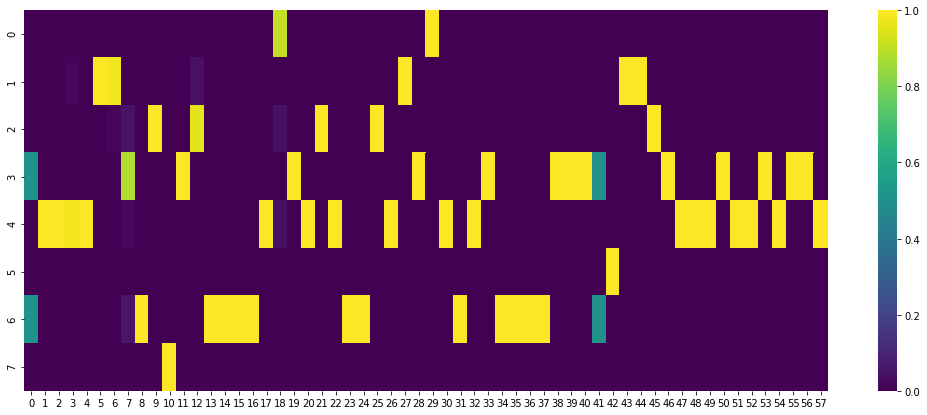

In [4]:
import seaborn as sns
from sklearn.metrics.cluster import contingency_matrix

cont_mat = pd.DataFrame(contingency_matrix(louv, spin))
#print(cont_mat.sum(axis=1))
cont_mat = cont_mat.divide(other = cont_mat.sum(axis=0),axis = 1)

fig, ax = plt.subplots(figsize=(18,7))

ann = np.copy(cont_mat)
sns.heatmap(cont_mat, ax=ax, cmap='viridis')

In [5]:
louv_matches, spin_matches = tuple(map(list, np.where(cont_mat > 0.8)))

In [6]:
import json

In [7]:
louv_matches = list(map(lambda x: 'louvain_'+str(x), louv_matches))
spin_matches = list(map(lambda x: 'spinglass_'+str(x), spin_matches))

In [8]:
parent_mapper = dict(zip(spin_matches, louv_matches))
parent_mapper.update({x:x for x in set(map(lambda x: 'spinglass_'+str(x), list(spinglass_clusters['cluster'].unique())))-set(parent_mapper.keys())})

In [9]:
parent_mapper

{'spinglass_18': 'louvain_0',
 'spinglass_29': 'louvain_0',
 'spinglass_5': 'louvain_1',
 'spinglass_6': 'louvain_1',
 'spinglass_27': 'louvain_1',
 'spinglass_43': 'louvain_1',
 'spinglass_44': 'louvain_1',
 'spinglass_9': 'louvain_2',
 'spinglass_12': 'louvain_2',
 'spinglass_21': 'louvain_2',
 'spinglass_25': 'louvain_2',
 'spinglass_45': 'louvain_2',
 'spinglass_7': 'louvain_3',
 'spinglass_11': 'louvain_3',
 'spinglass_19': 'louvain_3',
 'spinglass_28': 'louvain_3',
 'spinglass_33': 'louvain_3',
 'spinglass_38': 'louvain_3',
 'spinglass_39': 'louvain_3',
 'spinglass_40': 'louvain_3',
 'spinglass_46': 'louvain_3',
 'spinglass_50': 'louvain_3',
 'spinglass_53': 'louvain_3',
 'spinglass_55': 'louvain_3',
 'spinglass_56': 'louvain_3',
 'spinglass_1': 'louvain_4',
 'spinglass_2': 'louvain_4',
 'spinglass_3': 'louvain_4',
 'spinglass_4': 'louvain_4',
 'spinglass_17': 'louvain_4',
 'spinglass_20': 'louvain_4',
 'spinglass_22': 'louvain_4',
 'spinglass_26': 'louvain_4',
 'spinglass_30': '

In [10]:
edges_df = pd.read_csv('../data/Full_Kinome_Network_Compiled_weighted_pathways.txt', sep='\t', header=None)
total_edges = pd.concat([edges_df[0], edges_df[1]])

edges_df.head()

,0,1,2
0,PAK1,ERBB2,3.0
1,RON,YES,0.5
2,TYRO3,YES,0.5
3,LYN,KIT,0.5
4,KPCA,KIT,6.0


In [11]:
# get a list of the kinases
kin_list = list(spinglass_clusters['names'].unique())

# define the sizes
sizes = {n:int(np.log(np.sum(total_edges==n)+.01)+1) for n in spinglass_clusters['names'].unique()}
#sizes = {n:int(10) for n in spinglass_clusters['names'].unique()}

# handy to have a kin_arr
kin_arr = np.array(kin_list)

In [12]:
cluster_mapper = spin.to_dict()['cluster']
kin_parents = np.array([parent_mapper['spinglass_'+str(cluster_mapper[k])] for k in kin_list])
kin_children = np.array(['spinglass_'+str(cluster_mapper[k]) for k in kin_list if 'spinglass_'+str(cluster_mapper[k])])

In [13]:
parents = {par:set(kin_children[kin_parents==par].tolist()) for par in np.unique(kin_parents).tolist()}

In [14]:
# get parents plus children for parents != children
parents_plus_children = {x:{z:kin_arr[kin_children==z].tolist() for z in y if(list(y)[0] != x)} for x,y in parents.items()}

# identify parents == children
missing_parents = [x for x,y in parents_plus_children.items() if len(y)<1]
print(missing_parents)

# update to add kinases to remove parents == children
parents_plus_children = {x:y for x,y in parents_plus_children.items() if x not in missing_parents}

# place parents == children into separate dict
missing_parents = {x:kin_arr[kin_parents==x].tolist() for x in missing_parents}

# display 
parents_plus_children

['spinglass_0', 'spinglass_41']


{'louvain_0': {'spinglass_29': ['STK39',
   'OXSR1',
   'WNK1',
   'WNK4',
   'LMTK1',
   'WNK2',
   'WNK3'],
  'spinglass_18': ['BMPR2',
   'TGFR2',
   'TGFR1',
   'AMHR2',
   'ACVL1',
   'BMR1B',
   'BMR1A',
   'AVR2B',
   'ACV1B',
   'TSSK1',
   'DAPK2',
   'ACVR1',
   'NEK8',
   'STK35',
   'CDKL1',
   'MYO3A',
   'TSSK4',
   'AVR2A',
   'SG196',
   'VRK2',
   'ACV1C',
   'ST17B']},
 'louvain_1': {'spinglass_5': ['KSYK', 'BTK', 'ZAP70', 'LCK'],
  'spinglass_43': ['JAK2'],
  'spinglass_6': ['VGFR1',
   'TYK2',
   'KPCD',
   'KPCT',
   'PK3CG',
   'PK3CA',
   'E2AK2',
   'IKKB',
   'KPCZ',
   'GSK3A',
   'KPCB',
   'GSK3B',
   'PDPK1',
   'RIPK4',
   'PK3CB',
   'AKT3',
   'KPCI',
   'IKKA',
   'M3K14',
   'SMG1',
   'JAK3',
   'KS6B1',
   'ILK',
   'SGK1',
   'PDK2',
   'PDK1',
   'RIPK1',
   'E2AK3',
   'RIPK3',
   'SGK3',
   'KS6B2',
   'KPCL',
   'AKT1',
   'E2AK4',
   'IGF1R',
   'VGFR3',
   'JAK1',
   'PI42B',
   'TBK1',
   'CSF1R',
   'AKT2',
   'TRIB3',
   'IKKE',
   'PK3CD',

In [15]:
j = {"name":"viz",
     "children": [{"name": par}
                 for par in parents_plus_children.keys()]}

In [16]:
# first get the kinases of depth 3
json_out = {"name":"viz",
            "children":[
                {"name":str(parent), 
                "children":[
                    {"name":str(child), 
                    "children":[
                        {"name":str(k),
                        "size":int(sizes[k])} 
                        for k in kinases]}
                     for child, kinases in children.items()]} 
                for parent, children in parents_plus_children.items()]}

# extra json
missing_json = [
    {"name":str(parent),
    "children":[
        {"name":str(k),
        "size":int(sizes[k])}
        for k in kinases]}
    for parent, kinases in missing_parents.items()]

json_out["children"] = json_out["children"] + missing_json

In [17]:
# str_out is a JSON-formatted string from the json_out dictionary
# the 'replace' steps make the file more human-readable for debugging, etc
str_out = json.dumps(json_out).replace("},", "}, \n").replace('[{', '[\n{\n').replace(']},', ']}\n,\n')

In [18]:
with open('../viz/circle_pack_viz/dist/viz.json', 'w') as f:
    f.write(str_out)